<a href="https://colab.research.google.com/github/azhgh22/Walmart-Recruiting-Store-Sales-Forecasting/blob/main/notebooks/statistical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting
! unzip walmart-recruiting-store-sales-forecasting.zip
! rm walmart-recruiting-store-sales-forecasting.zip
! unzip features.csv.zip
! rm features.csv.zip
! unzip train.csv.zip
! rm train.csv.zip
! unzip test.csv.zip
! rm test.csv.zip
! unzip sampleSubmission.csv.zip
! rm sampleSubmission.csv.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 36.7 MB/s eta 0:00:00
Mounted at /content/drive
  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 788MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


## **Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

In [59]:
TRAIN_SIZE = 0.7

In [5]:
train['Date'] = pd.to_datetime(train['Date'])
train = train.sort_values(by='Date')

In [78]:
class TimeSeriesSplit:
    def __init__(self, train_size:int) -> None:
        self.train_size = train_size
        self.val_size = 1 - train_size

    def split(self, data:pd.DataFrame) -> tuple[pd.DataFrame,pd.DataFrame]:
        data = data.copy().sort_values(by='Date')
        start_week = data['Date'].min()
        end_week = data['Date'].max()
        data['Date'] = ((data['Date'] - start_week).dt.days // 7).astype(int)
        train_data = data.iloc[:int(self.train_size*data.shape[0])]
        val_data = data.iloc[int(self.train_size*data.shape[0]):]
        return train_data, val_data

In [70]:
class Filter:
  def get_query(self) -> str:
    pass

In [77]:
class DataFilter:
    def filter(self, data:pd.DataFrame, filter:Filter) -> pd.DataFrame:
        return data.query(filter.get_query())

In [75]:
class ComposeFilter(Filter):
    def __init__(self, filter_list:list[Filter]) -> None:
        self.filter_list = filter_list

    def get_query(self) -> str:
        return ' and '.join([filter.get_query() for filter in self.filter_list])

In [82]:
class StoreFilter(Filter):
    def __init__(self, store_id:int) -> None:
        self.store_id = store_id

    def get_query(self) -> str:
        return f'Store=={self.store_id}'

In [83]:
class DeptFilter(Filter):
    def __init__(self, dept_id:int) -> None:
        self.dept_id = dept_id

    def get_query(self) -> str:
        return f'Dept=={self.dept_id}'

In [84]:
DataFilter().filter(train, ComposeFilter([StoreFilter(1),DeptFilter(1)]))

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
138,1,1,2012-09-28,18947.81,False
139,1,1,2012-10-05,21904.47,False
140,1,1,2012-10-12,22764.01,False
141,1,1,2012-10-19,24185.27,False


In [61]:
train_part, val_part = TimeSeriesSplit(TRAIN_SIZE).split(DataFilter().filter(train, [StoreFilter(1),DeptFilter(1)]))

In [117]:
class DeptKeeper:
    def __init__(self, data:pd.DataFrame,train_size:int,dept_id:int) -> None:
        self.train_mapping:dict[int,pd.DataFrame] = {}
        self.val_mapping:dict[int,pd.DataFrame] = {}
        for store in data['Store'].unique():
            compose_filter = ComposeFilter([StoreFilter(store),DeptFilter(dept_id)])
            filtered = DataFilter().filter(data, compose_filter)
            train_part, val_part = TimeSeriesSplit(train_size).split(filtered)
            self.train_mapping[store] = train_part
            self.val_mapping[store] = val_part

    def get_train(self,store_id:int) -> pd.DataFrame:
        return self.train_mapping[store_id].copy()

    def get_val(self,store_id:int) -> pd.DataFrame:
        return self.val_mapping[store_id].copy()

    def get_keys(self) -> list[int]:
        return list(self.train_mapping.keys())

In [118]:
dept1 = DeptKeeper(train,TRAIN_SIZE,1)

/tmp/ipython-input-119-2046573603.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', N)  # 20 distinct colors


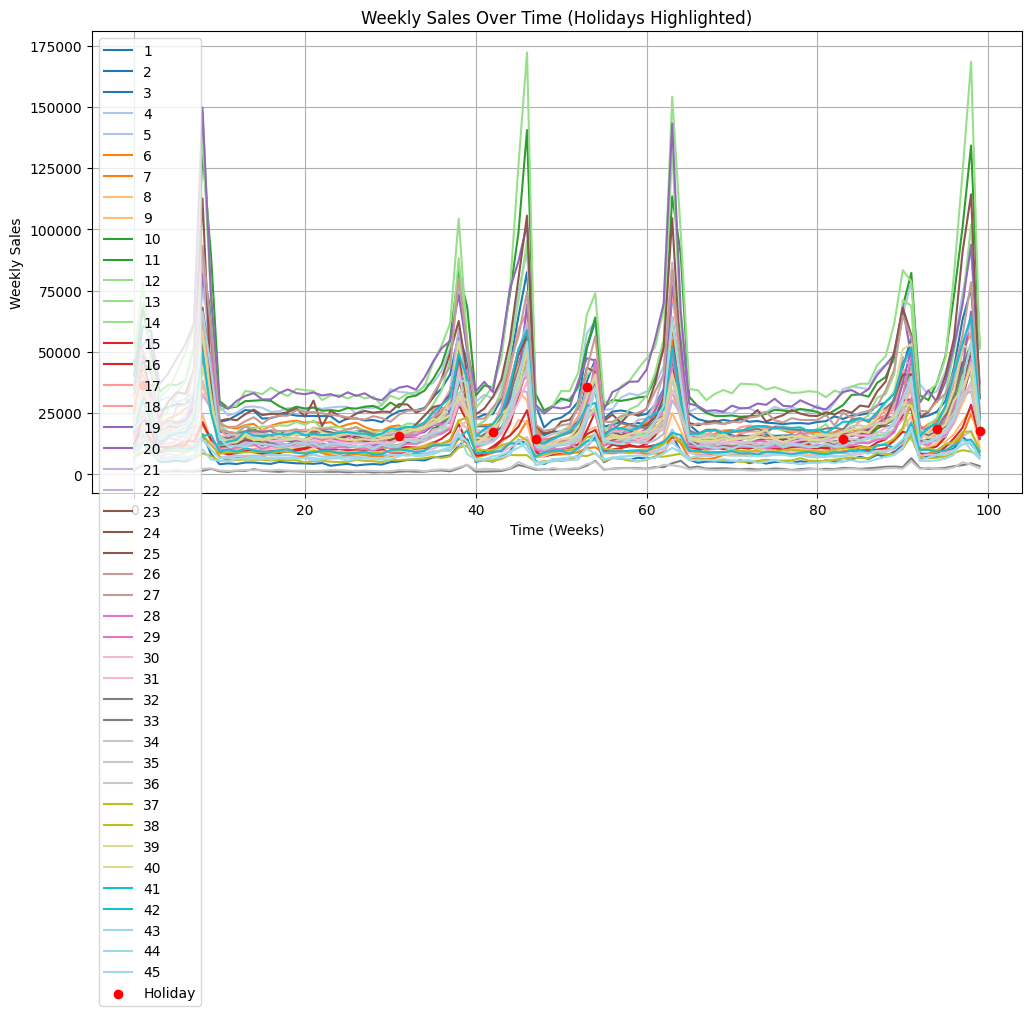

In [119]:
N = 45
cmap = plt.cm.get_cmap('tab20', N)  # 20 distinct colors

colors = [cmap(i) for i in range(N)]
holidays = dept1.get_train(22)[dept1.get_train(22)['IsHoliday'] == True]

plt.figure(figsize=(12, 6))
for s in sorted(dept1.get_keys()):
  plt.plot(dept1.get_train(s)['Date'], dept1.get_train(s)['Weekly_Sales'], label=f'{s}', color=colors[s-1])

plt.scatter(holidays['Date'], holidays['Weekly_Sales'], color='red', label='Holiday', zorder=5)
plt.title("Weekly Sales Over Time (Holidays Highlighted)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

In [120]:
dept1.get_train(1)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,0,24924.50,False
1,1,1,1,46039.49,True
2,1,1,2,41595.55,False
3,1,1,3,19403.54,False
4,1,1,4,21827.90,False
...,...,...,...,...,...
95,1,1,95,25293.49,False
96,1,1,96,33305.92,False
97,1,1,97,45773.03,False
98,1,1,98,46788.75,False


In [127]:
dfs = [dept1.get_train(s)[['Date','Weekly_Sales']] for s in dept1.get_keys()]

# Ensure datetime and rename
for i, df in enumerate(dfs):
    # df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Weekly_Sales': f'Sales{i+1}'}, inplace=True)

# Merge all on 'Date'
from functools import reduce
merged = reduce(lambda left, right: pd.merge(left, right, on='Date'), dfs)

# Compute average
merged['Avg_Sales'] = merged[[col for col in merged.columns if col.startswith('Sales')]].mean(axis=1)

In [130]:
merged

,Date,Sales1,Sales2,Sales3,Sales4,Sales5,Sales6,Sales7,Sales8,Sales9,...,Sales37,Sales38,Sales39,Sales40,Sales41,Sales42,Sales43,Sales44,Sales45,Avg_Sales
0,0,24924.50,14715.68,35034.06,23176.07,32313.79,18187.71,22675.43,10158.77,17309.89,...,22252.71,20686.31,15501.96,12239.38,12786.85,20304.23,6871.20,18628.11,6476.76,19596.298000
1,1,46039.49,25741.59,60483.70,40543.21,50566.61,30255.61,36390.07,14346.05,31931.41,...,38184.43,36372.35,26220.41,23252.04,18305.60,40434.79,12315.65,22416.94,18597.64,32381.831111
2,2,41595.55,18411.25,58221.52,30763.19,42607.96,27499.80,25515.17,12321.18,24879.99,...,26068.39,23035.70,26567.03,17391.31,13714.98,23375.58,7751.11,28756.53,9939.45,24850.163556
3,3,19403.54,11489.09,25962.32,21378.38,17493.55,14869.90,18008.32,10099.28,12892.24,...,16951.62,14843.93,12887.75,9236.15,11182.72,16343.01,6014.71,14656.08,6460.56,15142.035111
4,4,21827.90,14805.98,27372.05,21078.92,17758.17,15084.71,19313.36,9719.90,17968.64,...,19966.98,19011.63,11969.74,10900.64,10996.97,17728.27,6120.60,16608.87,6939.08,16947.834889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,25293.49,16288.92,29959.08,22597.77,32923.32,16875.07,24853.21,8797.14,19656.50,...,22582.95,28085.66,15458.52,15210.42,11075.50,26496.28,7891.92,18324.66,6381.70,20895.282444
96,96,33305.92,24818.11,43639.97,27672.81,42023.42,22576.29,31105.40,9873.17,25778.90,...,32820.81,38605.59,21261.92,22084.64,14653.15,38675.68,9705.88,23323.18,7946.35,28540.342667
97,97,45773.03,33350.92,63109.72,36015.58,56602.65,32755.41,42924.71,12119.49,34294.43,...,50844.88,53608.57,32037.96,31539.28,18978.16,49784.63,12158.20,37983.83,14245.97,39784.668444
98,98,46788.75,47196.72,75779.45,43037.04,78431.10,35862.07,52859.06,13695.74,49692.85,...,63868.79,60924.13,33878.68,43921.97,28386.85,58218.90,12738.13,53942.21,9839.39,49563.195556


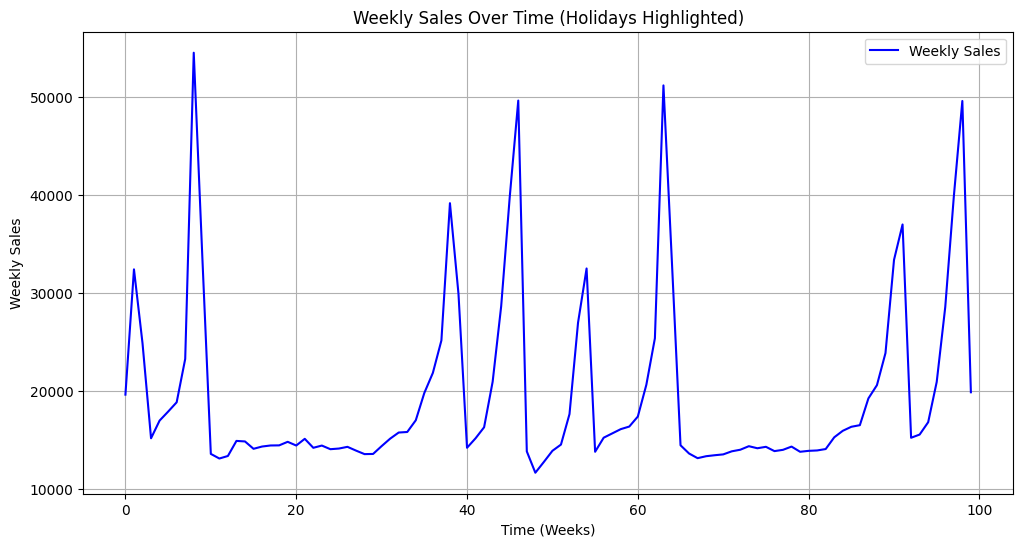

In [129]:
# holidays = dept1.get_train(1)[train_part['IsHoliday'] == True]

plt.figure(figsize=(12, 6))
plt.plot(merged['Date'], merged['Avg_Sales'], label='Weekly Sales', color='blue')
# plt.scatter(holidays['Date'], holidays['Weekly_Sales'], color='red', label='Holiday', zorder=5)

plt.title("Weekly Sales Over Time (Holidays Highlighted)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

In [131]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(merged['Avg_Sales'].dropna())

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("✅ Series is likely stationary (reject H0)")
else:
    print("❌ Series is likely non-stationary (fail to reject H0)")

ADF Statistic: -6.4150040235742285
p-value: 1.850590164242628e-08
✅ Series is likely stationary (reject H0)


<Figure size 1000x500 with 0 Axes>

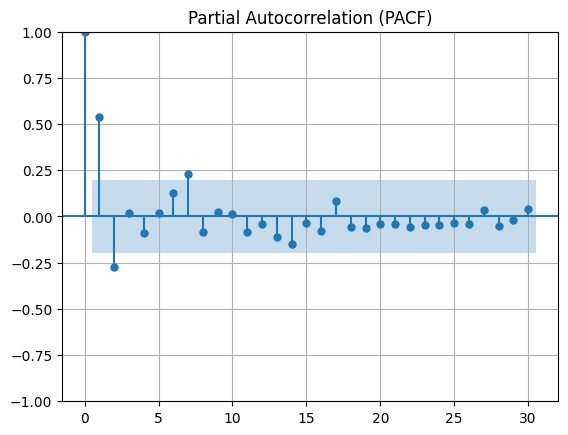

In [132]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10, 5))
plot_pacf(merged['Avg_Sales'], lags=30, method='ywm')  # or method='ld', 'ols', etc.
plt.title("Partial Autocorrelation (PACF)")
plt.grid(True)
plt.show()